# Non model based

In [1]:
import os
import re
import math
import pandas as pd
import seaborn as sns
from string import punctuation
import matplotlib.pyplot as plt

In [2]:
here = os.getcwd()
project_path = os.path.dirname(here)
data_path = os.path.join(project_path, "data", "session_speech.csv")

In [3]:
data = pd.read_csv(data_path, converters={"speech":eval})
data.columns

Index(['name', 'vote', 'speech'], dtype='object')

In [4]:
data.shape

(70, 3)

In [5]:
data = data.explode(column="speech")
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 3)

In [6]:
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(rf"[{punctuation}\“\”\¿\¡\−\…]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [7]:
data["speech_prep"] = data.speech.apply(preprocess)
data.head()

,name,vote,speech,speech_prep
0,Ana Claudia Almirón,positivo,"Hace dos años, tuvimos una sesión histórica cu...",hace dos años tuvimos una sesión histórica cua...
1,Roberto Gustavo Basualdo,negativo,"Gracias, señor presidente. Hoy es un día en el...",gracias señor presidente hoy es un día en el q...
2,Pablo Daniel Blanco,negativo,Como voy a pedir la inserción de mis argumento...,como voy a pedir la inserción de mis argumento...
3,Inés Imelda Blas,negativo,"Gracias, presidenta. Nuevamente, nos encontram...",gracias presidenta nuevamente nos encontramos ...
4,Néstor Braillard Poccard,negativo,"Gracias, señora presidenta. Realmente, como di...",gracias señora presidenta realmente como dijer...


## Difference of frequencies

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(data.speech_prep)
X = X.toarray()
frequencies = (
    pd
    .DataFrame(
        X, columns=vectorizer.get_feature_names_out(), index=data["vote"]
    )
    .rename_axis("senator_vote", axis=0)
    .reset_index()
    .groupby("senator_vote")
    .sum()
)
frequencies

,abajo,abandonada,abandonadas,abandonar,abandono,abarca,abdominales,aberración,aberrante,aberrantes,...,último,últimos,única,únicamente,únicas,único,únicos,útero,úteros,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,1,0,0,1,1,2,0,1,0,1,...,8,2,4,0,0,5,1,3,0,1
positivo,1,1,1,0,0,0,1,0,1,0,...,10,9,8,1,3,7,1,3,1,0


In [10]:
count_total = frequencies.sum(axis=0)
count_difference = frequencies.loc["positivo"]-frequencies.loc["negativo"]
count_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": count_difference,
        "pos": frequencies.loc["positivo"],
        "neg": frequencies.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
count_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0,1,1
1,abandonada,1,1,1,0
2,abandonadas,1,1,1,0
3,abandonar,1,-1,0,1
4,abandono,1,-1,0,1


## Difference of proportions

In [11]:
proportions = frequencies.div(frequencies.sum(axis=1), axis=0)
proportions_difference = proportions.loc["positivo"]-proportions.loc["negativo"]
proportions_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_difference,
        "pos": proportions.loc["positivo"],
        "neg": proportions.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_diff.head()

,word,total,diff,pos,neg
0,abajo,2,-0.000016,0.000019,0.000035
1,abandonada,1,0.000019,0.000019,0.000000
2,abandonadas,1,0.000019,0.000019,0.000000
3,abandonar,1,-0.000035,0.000000,0.000035
4,abandono,1,-0.000035,0.000000,0.000035


## Correction: removing stop words

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/macarena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stw = stopwords.words("spanish")
print(stw)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [14]:
proportions_wo_stopwords = (
    proportions_diff[~proportions_diff["word"].isin(stw)]
    .reset_index(drop=True)
)
proportions_wo_stopwords.head()

,word,total,diff,pos,neg
0,abajo,2,-0.000016,0.000019,0.000035
1,abandonada,1,0.000019,0.000019,0.000000
2,abandonadas,1,0.000019,0.000019,0.000000
3,abandonar,1,-0.000035,0.000000,0.000035
4,abandono,1,-0.000035,0.000000,0.000035


## Odds

In [15]:
odds_pos = frequencies.loc["positivo"]/frequencies.loc["negativo"]
odds_neg = frequencies.loc["negativo"]/frequencies.loc["positivo"]
odds_difference = odds_pos/odds_neg
odds_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": odds_difference,
        "pos": odds_pos,
        "neg": odds_neg
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
odds_diff.head()

,word,total,diff,pos,neg
0,abajo,2,1.0,1.0,1.0
1,abandonada,1,inf,inf,0.0
2,abandonadas,1,inf,inf,0.0
3,abandonar,1,0.0,0.0,inf
4,abandono,1,0.0,0.0,inf


## Log-odds-ratio

Agregar suavizado, pero cuidado: no se puede agregar peso sin más a una frecuencia (la suma ya no va a dar 1).

In [16]:
from numpy import log
from copy import deepcopy

In [17]:
log_odds_diff = deepcopy(odds_diff)
log_odds_diff["diff"] = log(log_odds_diff["diff"])
log_odds_diff.head()

/home/macarena/repos/eddc/eddc-specialization-project/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,abajo,2,0.0,1.0,1.0
1,abandonada,1,inf,inf,0.0
2,abandonadas,1,inf,inf,0.0
3,abandonar,1,-inf,0.0,inf
4,abandono,1,-inf,0.0,inf


In [18]:
smooth_log_odds_diff = deepcopy(odds_diff)
smooth_log_odds_diff["diff"] = smooth_log_odds_diff["diff"].apply(
    lambda x: log(x+0.5) if x==0 else log(x)
)
smooth_log_odds_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0.000000,1.0,1.0
1,abandonada,1,inf,inf,0.0
2,abandonadas,1,inf,inf,0.0
3,abandonar,1,-0.693147,0.0,inf
4,abandono,1,-0.693147,0.0,inf


## Correction: elimating low-frequency words

## TF-IDF

In [19]:
import numpy as np
from itertools import chain

In [20]:
discourses = list(map(lambda x: set(x.split()),data.speech_prep.tolist()))
words = sorted(list(set(chain(*discourses))))

X = np.zeros((len(discourses), len(words)))

for i in range(len(words)):
    for j in range(len(discourses)):
        if words[i] in discourses[j]:
            X[j,i] += 1

df = (
    pd.DataFrame(X, columns=words)
    .filter(frequencies.columns)
    .sum(axis=0)
)
tfidf = proportions*log(1/df)
tfidf


,abajo,abandonada,abandonadas,abandonar,abandono,abarca,abdominales,aberración,aberrante,aberrantes,...,último,últimos,única,únicamente,únicas,único,únicos,útero,úteros,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,-0.000024,0.0,0.0,0.0,0.0,-0.000048,0.0,0.0,0.0,0.0,...,-0.000711,-0.000160,-0.000319,0.0,-0.000000,-0.000399,-0.000024,-0.000167,0.0,0.0
positivo,-0.000013,0.0,0.0,0.0,0.0,-0.000000,0.0,0.0,0.0,0.0,...,-0.000479,-0.000387,-0.000344,0.0,-0.000062,-0.000301,-0.000013,-0.000090,0.0,0.0


In [21]:
tfidf_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": tfidf.loc["positivo"]-tfidf.loc["negativo"],
        "pos": tfidf.loc["positivo"],
        "neg": tfidf.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
tfidf_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0.000011,-0.000013,-0.000024
1,abandonada,1,0.000000,0.000000,0.000000
2,abandonadas,1,0.000000,0.000000,0.000000
3,abandonar,1,0.000000,0.000000,0.000000
4,abandono,1,0.000000,0.000000,0.000000


In [22]:
corr_prop = tfidf_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: -0.97


## WordScores

In [23]:
wkw = (
    (proportions.loc["positivo"]-proportions.loc["negativo"])/
    (proportions.loc["positivo"]+proportions.loc["negativo"])
)
nkw = frequencies.sum(axis=0) / frequencies.sum().sum()

wkw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": wkw*nkw,
        "wkw": wkw,
        "nkw": nkw
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
wkw_diff.head()

,word,total,diff,wkw,nkw
0,abajo,2,-0.000007,-0.299228,0.000024
1,abandonada,1,0.000012,1.000000,0.000012
2,abandonadas,1,0.000012,1.000000,0.000012
3,abandonar,1,-0.000012,-1.000000,0.000012
4,abandono,1,-0.000012,-1.000000,0.000012


## Visualizations

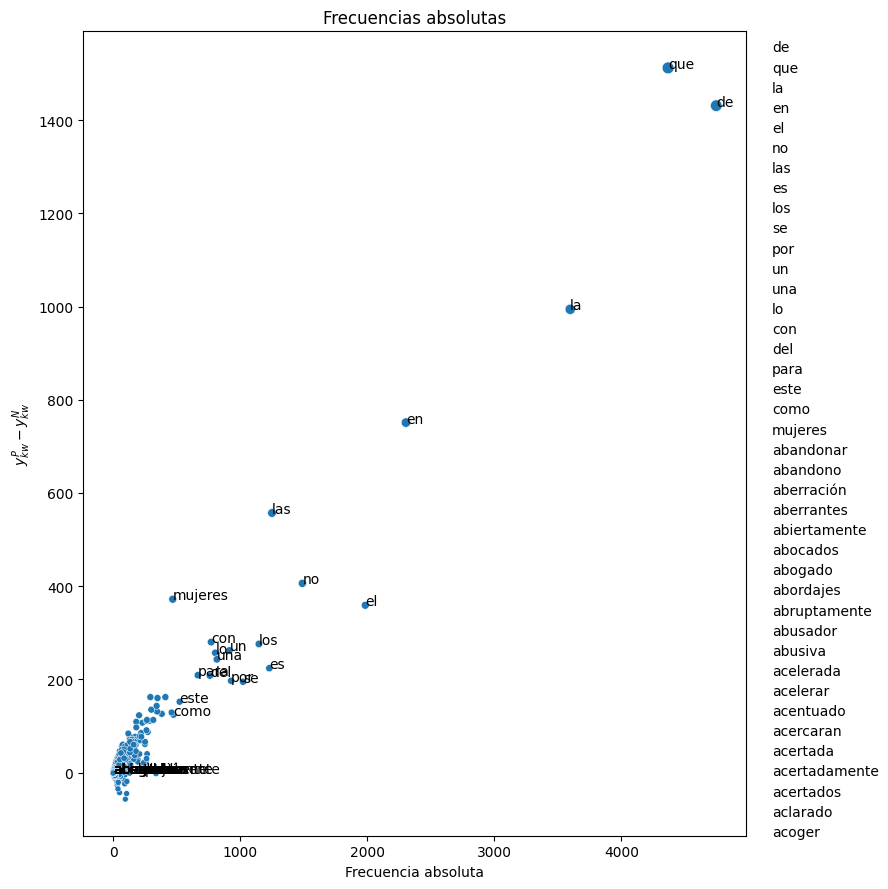

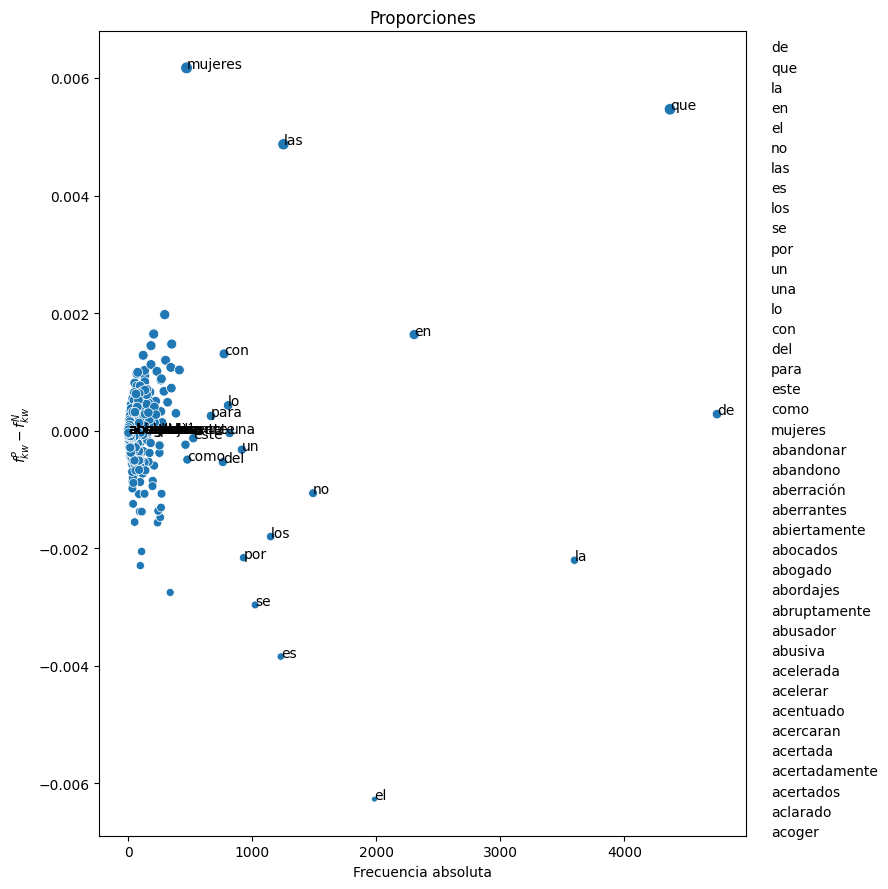

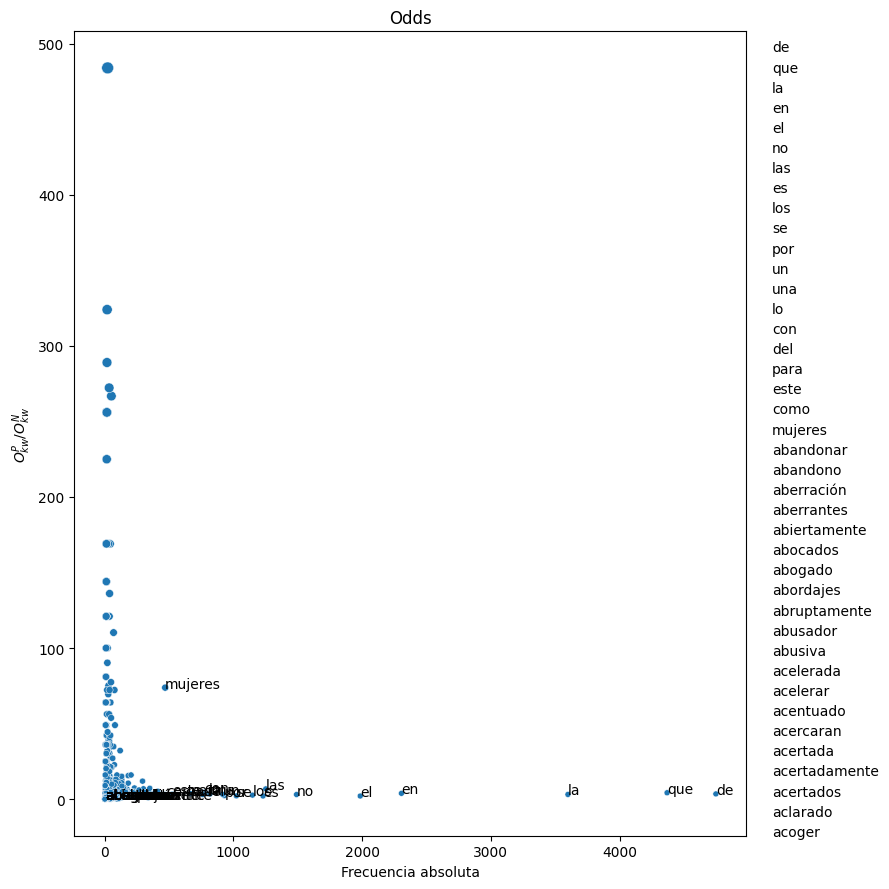

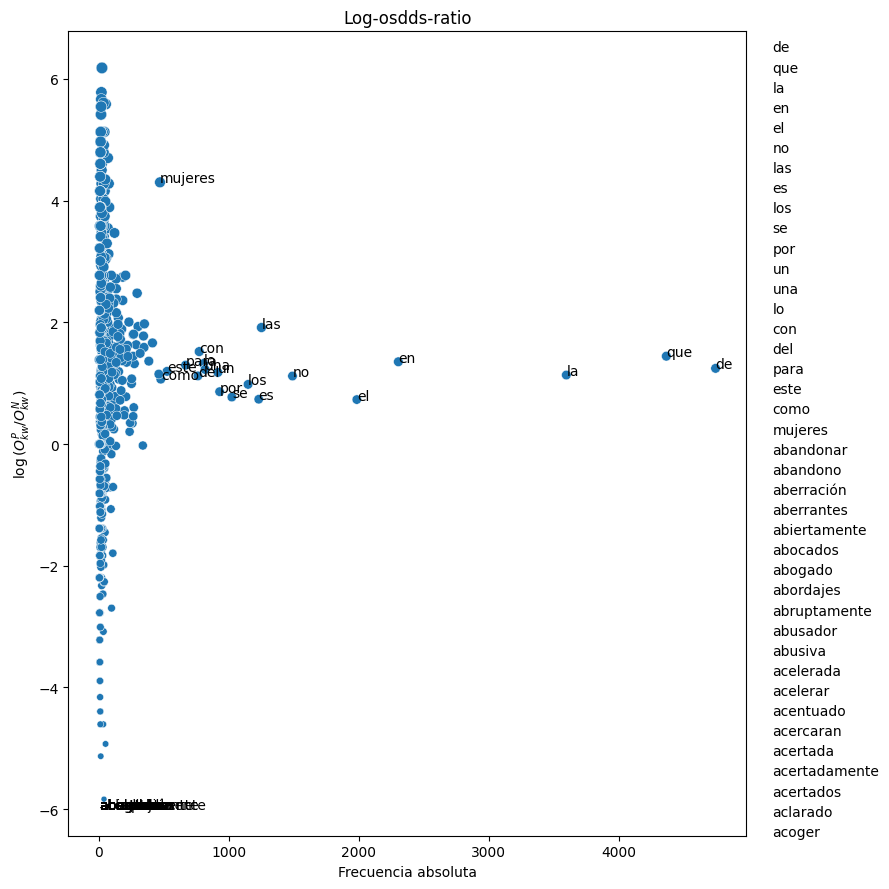

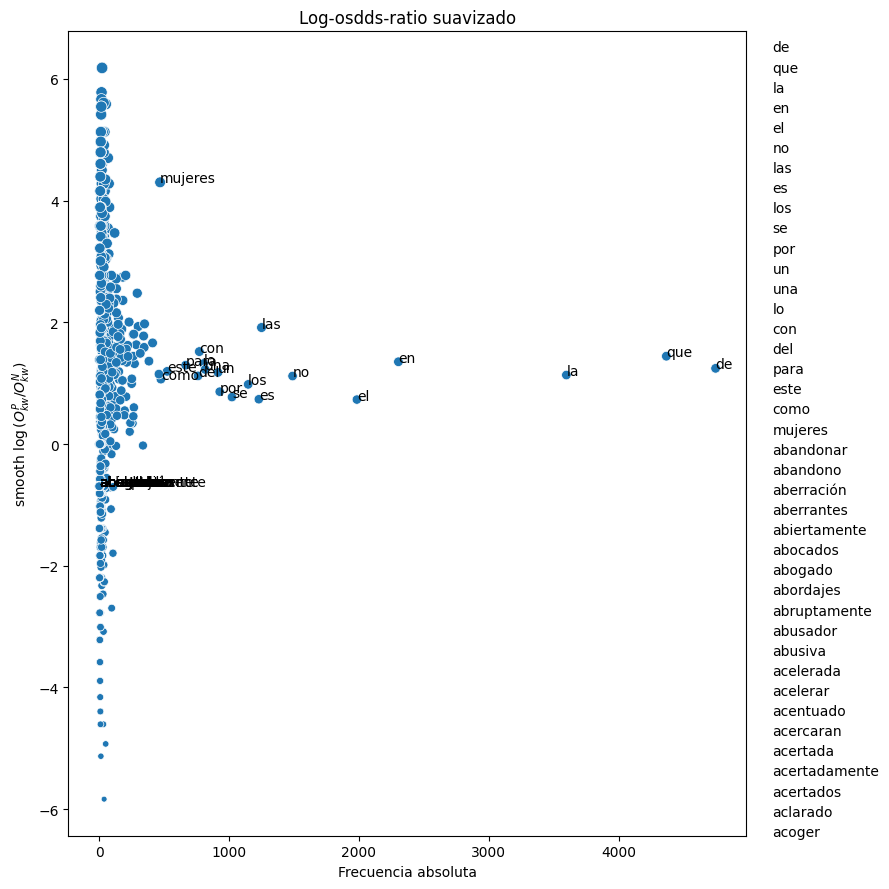

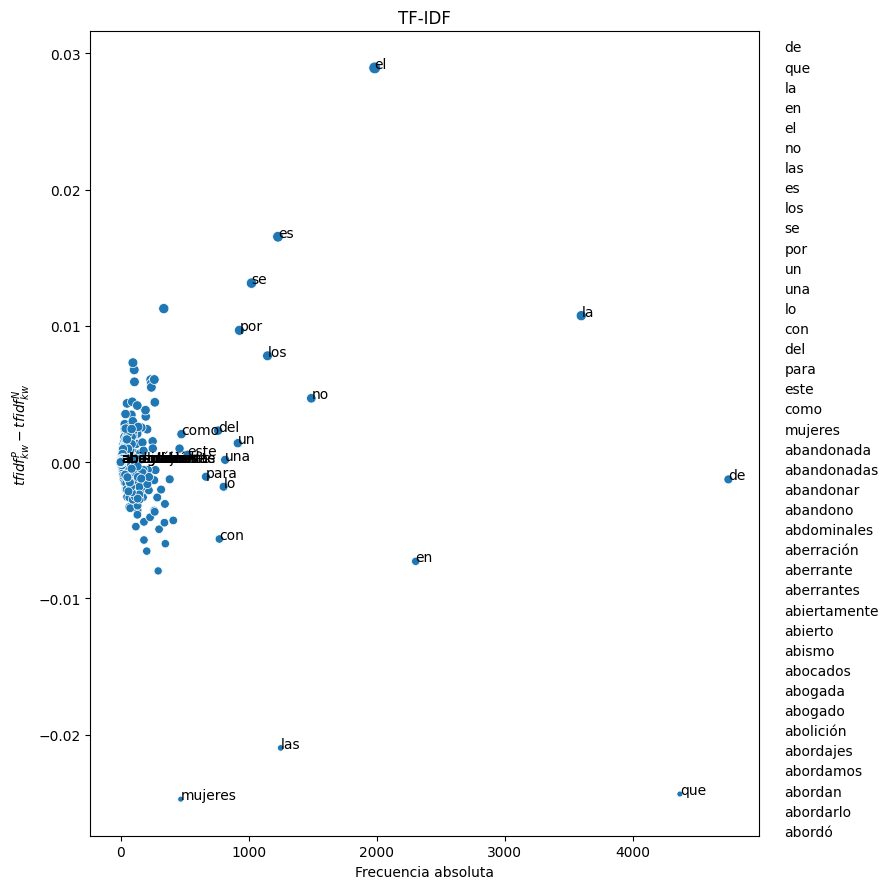

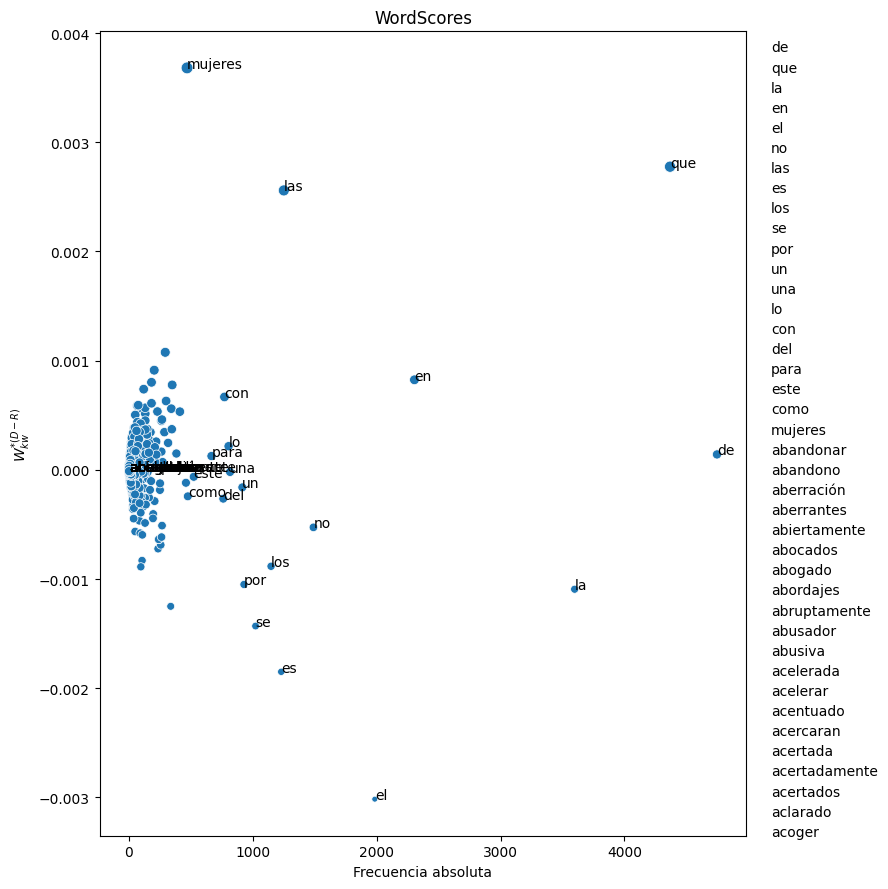

In [165]:
stats = [
    count_diff, proportions_diff, odds_diff, log_odds_diff,
    smooth_log_odds_diff, tfidf_diff, wkw_diff
]
titles = [
    "Frecuencias absolutas", "Proporciones", "Odds", "Log-osdds-ratio",
    "Log-osdds-ratio suavizado", "TF-IDF", "WordScores"
]
y_labels = [
    "$y^{P}_{kw}-y^{N}_{kw}$", "$f^{P}_{kw}-f^{N}_{kw}$", "$O^{P}_{kw}/O^{N}_{kw}$",
    "$\log{(O^{P}_{kw}/O^{N}_{kw})}$", "smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$",
    "$tfidf^{P}_{kw}-tfidf^{N}_{kw}$", "$W^{*(D-R)}_{kw}$"
]
for df, title, y_label in zip(stats,titles,y_labels):
    fig, ax = plt.subplots(figsize=(9,9))
    df_copy = deepcopy(df)
    _max = df_copy["diff"].sort_values().unique().tolist()[-2]
    _min = df_copy["diff"].sort_values().unique().tolist()[2]
    df_copy["size"] = df_copy["diff"].apply(
        lambda x: math.ceil(_max)
        if x==math.inf
        else x
    )
    df_copy["size"] = df_copy["size"].apply(
        lambda x: math.floor(_min)
        if x==-math.inf
        else x
    )
    sns.scatterplot(df_copy, x="total", y="diff", size=df_copy["size"], ax=ax)
    words = pd.concat([
     df_copy.nlargest(n=20, columns=["total", "size"], keep="first"),
     df_copy.nsmallest(n=20, columns=["total", "size"], keep="first")
    ])
    words["text_size"] = words["size"].apply(log)
    for e, (i, row) in enumerate(words.iterrows(), start=1):
        ax.text(
            row["total"], row["size"], row["word"],
            horizontalalignment='left', color='black'
        )
        ylim_min, ylim_max = ax.get_ylim()
        ylim_div = (ylim_max-ylim_min)/40
        ax.text(
            ax.get_xlim()[1]+200, ylim_max-(e*ylim_div), row["word"],
            horizontalalignment='left', color='black'
        )
        
        
    ax.set_title(title)
    ax.set_xlabel("Frecuencia absoluta")
    ax.set_ylabel(y_label)
    ax.get_legend().set_visible(False)
    plt.tight_layout()
    filename = title.lower().replace(" ", "_")
    plt.savefig(f"{project_path}/visualizations/stats__{filename}.png")


Ideas:
- en esta nb, hacer las visualizaciones propuestas por el paper para todos los casos
- en la nb de clasificación voy a necesitar features, puedo elegir alguna de estas técnicas visualizando con 
- 

Observaciones:

- en freq. abs. casi no hay palabras negativas, esto puede ser porque:
  - los neg hablaron menos (personas)
  - los neg tienen discursos más breves
  - los neg no usaron palabras que se distingan de pos (en términos de freq. abs.)
  - ... seguir explorando